In [5]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
import sklearn.model_selection as sms
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
import smogn
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
import random
from scipy import ndimage
from util import pyvis
from util import extract
from loader import data_loader
from IPython.display import HTML
import util
import smogn
from smogn.phi import phi
from smogn.phi_ctrl_pts import phi_ctrl_pts
import warnings
from multiprocessing import Pool
import sklearn.linear_model as skl
import sklearn.neural_network as snn

In [6]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [7]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

In [8]:
for j in np.arange(len(X_all_c)):

    X_train = np.delete(X_all_c,j,axis=0)
    y_train = np.delete(per_change,j)
    X_test = X_all_c[j,:,:]
    y_test = per_change[j]
    train_index = np.arange(len(X_all_c))[np.arange(len(X_all_c))!=j]
    test_index = j

    X0_tt,scaler = util.make_feature_matrix(X_train,pre_updrs_off[train_index])
    entropy0 = util.calc_entropy(X0_tt.ravel())
    X_smogn1,y_smogn1 = util.rad_smogn(X0_tt,
                                                    y_train,
                                                    np.max(y_train),
                                                    np.mean(y_train),
                                                    1,0,0.5,0.02)
    X_smogn2,y_smogn2 = util.rad_smogn(X0_tt,
                                                    y_train,
                                                    np.min(y_train),
                                                    np.mean(y_train),
                                                    1,0,0.5,0.05)
    X_smogn3,y_smogn3 = util.rad_smogn(X0_tt,
                                                    y_train,
                                                    np.min(y_train),
                                                    np.mean(y_train),
                                                    1,0,0.5,0.075)
    X_smogn4,y_smogn4 = util.rad_smogn(X0_tt,
                                                    y_train,
                                                    np.min(y_train),
                                                    np.mean(y_train),
                                                    1,0,0.5,0.1)


    X_train_aug = np.vstack((X0_tt,X_smogn1,X_smogn2,X_smogn3,X_smogn4))
    entropy_aug = util.calc_entropy(X_train_aug.ravel())
    print('Entropy of augmented features is',str(entropy_aug),'and of entropy original features is',str(entropy0))
    y_train_aug = np.hstack((y_train.ravel(),y_smogn1.ravel(),y_smogn2.ravel(),
                            y_smogn3.ravel(),y_smogn4.ravel()))
    X_train_aug = X_train_aug[y_train_aug>0,:]
    y_train_aug = y_train_aug[y_train_aug>0]

    scaler00 = StandardScaler()
    X_train_aug = scaler00.fit_transform(X_train_aug)

    # Predict
    reg_l = snn.MLPRegressor(hidden_layer_sizes=(X_train.shape[1],X_train.shape[2]),
                            activation='relu',
                            max_iter=1000,
                            tol=1e-6,
                            solver='adam',
                            epsilon=1e-1,
                            alpha=1,
                            verbose=True,
                            n_iter_no_change=700,
                            early_stopping=True,
                            random_state=1,
                            warm_start=True,
                            batch_size=1).fit(X_train_aug,y_train_aug)


    X_test_in = util.scale_feature_matrix(np.expand_dims(X_test,axis=0),pre_updrs_off[test_index],scaler)
    ut_l = reg_l.predict(X_test_in.reshape(X_test_in.shape[0],X_test_in.shape[1]*X_test_in.shape[2]))
    lr_pred_qr = linregress(np.asarray(ut_l).ravel(),y_test)
    print('Predicted improvement of ',ut_l, 'with true improvement', y_test)
    lr = linregress(np.asarray(ut_l).ravel(),y_test)
    lr.rvalue


Prior to SMOGN sampling, mean is 2.7357353525324407e-17 standard deviation is 0.959551639241436


dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.55s/it]


(32, 9576)
After SMOGN sampling, mean is 0.02220407030583311 standard deviation is 1.0102673279265886
After rescaling, SMOGN mean is 0.02220407030583311 standard deviation is 1.0102673279265886
Prior to SMOGN sampling, mean is 2.7357353525324407e-17 standard deviation is 0.959551639241436


r_index: 100%|##########| 1/1 [00:01<00:00,  1.37s/it]


(38, 9576)
After SMOGN sampling, mean is 0.052566700855837006 standard deviation is 0.7735803107530494
After rescaling, SMOGN mean is 0.052566700855837006 standard deviation is 0.7735803107530494
Prior to SMOGN sampling, mean is 2.7357353525324407e-17 standard deviation is 0.959551639241436


r_index: 100%|##########| 1/1 [00:02<00:00,  2.21s/it]


(38, 9576)
After SMOGN sampling, mean is 0.08456430092492853 standard deviation is 0.855001924217315
After rescaling, SMOGN mean is 0.08456430092492853 standard deviation is 0.855001924217315
Prior to SMOGN sampling, mean is 2.7357353525324407e-17 standard deviation is 0.959551639241436


r_index: 100%|##########| 1/1 [00:01<00:00,  1.59s/it]


(38, 9576)
After SMOGN sampling, mean is 0.05394544157999083 standard deviation is 0.7968705310657475
After rescaling, SMOGN mean is 0.05394544157999083 standard deviation is 0.7968705310657475
Entropy of augmented features is 15.896140425487173 and of entropy original features is 17.25278264595954
Iteration 1, loss = 52.75213247
Validation score: -1.537292
Iteration 2, loss = 35.79585696
Validation score: -0.762051
Iteration 3, loss = 20.95875012
Validation score: -0.503894
Iteration 4, loss = 11.18601151
Validation score: -0.528574
Iteration 5, loss = 5.65365309
Validation score: -0.478758
Iteration 6, loss = 2.81217208
Validation score: -0.517737
Iteration 7, loss = 1.43581837
Validation score: -0.472149
Iteration 8, loss = 0.78321747
Validation score: -0.452834
Iteration 9, loss = 0.46916667
Validation score: -0.414830
Iteration 10, loss = 0.31119597
Validation score: -0.410522
Iteration 11, loss = 0.22793550
Validation score: -0.374162
Iteration 12, loss = 0.18234147
Validation sc

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Predicted improvement of  [0.8517239] with true improvement 0.48333333333333334
Prior to SMOGN sampling, mean is 1.6259559170711675e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 1/1 [00:01<00:00,  1.49s/it]


(33, 9576)
After SMOGN sampling, mean is 0.01347014307912367 standard deviation is 0.9761648001718158
After rescaling, SMOGN mean is 0.01347014307912367 standard deviation is 0.9761648001718158
Prior to SMOGN sampling, mean is 1.6259559170711675e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:07<00:00,  1.46s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08155443765183255 standard deviation is 0.770263977730434
After rescaling, SMOGN mean is 0.08155443765183255 standard deviation is 0.770263977730434
Prior to SMOGN sampling, mean is 1.6259559170711675e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:07<00:00,  1.53s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10926252910495089 standard deviation is 0.8475993813389524
After rescaling, SMOGN mean is 0.10926252910495089 standard deviation is 0.8475993813389524
Prior to SMOGN sampling, mean is 1.6259559170711675e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:07<00:00,  1.58s/it]


(40, 9576)
After SMOGN sampling, mean is 0.11036732655093377 standard deviation is 0.852583892432222
After rescaling, SMOGN mean is 0.11036732655093377 standard deviation is 0.852583892432222
Entropy of augmented features is 15.810069190474406 and of entropy original features is 17.249540489120047
Iteration 1, loss = 52.57421289
Validation score: -3.562467
Iteration 2, loss = 35.17593712
Validation score: -1.144931
Iteration 3, loss = 20.24007859
Validation score: -0.247693
Iteration 4, loss = 10.60468872
Validation score: -0.220017
Iteration 5, loss = 5.28125157
Validation score: -0.440846
Iteration 6, loss = 2.61847691
Validation score: -0.748132
Iteration 7, loss = 1.35404858
Validation score: -0.642915
Iteration 8, loss = 0.76503395
Validation score: -0.874840
Iteration 9, loss = 0.48155861
Validation score: -0.669512
Iteration 10, loss = 0.33388491
Validation score: -0.648653
Iteration 11, loss = 0.25512980
Validation score: -0.583711
Iteration 12, loss = 0.21145130
Validation sco

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.54s/it]


(34, 9576)
After SMOGN sampling, mean is 0.010986725834750669 standard deviation is 0.8989233477377319
After rescaling, SMOGN mean is 0.010986725834750669 standard deviation is 0.8989233477377319
Prior to SMOGN sampling, mean is 7.252279566619017e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.52s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09834577543321177 standard deviation is 0.804271721645536
After rescaling, SMOGN mean is 0.09834577543321177 standard deviation is 0.804271721645536
Prior to SMOGN sampling, mean is 7.252279566619017e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.50s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08175422056435046 standard deviation is 0.7629622242096847
After rescaling, SMOGN mean is 0.08175422056435046 standard deviation is 0.7629622242096847
Prior to SMOGN sampling, mean is 7.252279566619017e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.57s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08742243051269524 standard deviation is 0.8213613085881488
After rescaling, SMOGN mean is 0.08742243051269524 standard deviation is 0.8213613085881488
Entropy of augmented features is 15.790000420027923 and of entropy original features is 17.2511000377312
Iteration 1, loss = 52.53940526
Validation score: -3.703366
Iteration 2, loss = 35.15282489
Validation score: -1.092216
Iteration 3, loss = 20.19719203
Validation score: -0.662916
Iteration 4, loss = 10.55629700
Validation score: -0.617018
Iteration 5, loss = 5.22619280
Validation score: -0.736181
Iteration 6, loss = 2.56006380
Validation score: -0.871595
Iteration 7, loss = 1.30134865
Validation score: -0.850822
Iteration 8, loss = 0.71459078
Validation score: -0.855254
Iteration 9, loss = 0.43397757
Validation score: -0.805307
Iteration 10, loss = 0.29279045
Validation score: -0.839840
Iteration 11, loss = 0.21924021
Validation score: -0.757632
Iteration 12, loss = 0.17880142
Validation sco

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.54s/it]


(34, 9576)
After SMOGN sampling, mean is 0.00015088577039214593 standard deviation is 0.9216631427822423
After rescaling, SMOGN mean is 0.00015088577039214593 standard deviation is 0.9216631427822423
Prior to SMOGN sampling, mean is 3.1228677137398614e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.56s/it]


(40, 9576)
After SMOGN sampling, mean is 0.1151402689757617 standard deviation is 0.8248067456794804
After rescaling, SMOGN mean is 0.1151402689757617 standard deviation is 0.8248067456794804
Prior to SMOGN sampling, mean is 3.1228677137398614e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.49s/it]


(40, 9576)
After SMOGN sampling, mean is 0.0722760427127078 standard deviation is 0.7388190096354372
After rescaling, SMOGN mean is 0.0722760427127078 standard deviation is 0.7388190096354372
Prior to SMOGN sampling, mean is 3.1228677137398614e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.67s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10255459210060966 standard deviation is 0.7706690045880096
After rescaling, SMOGN mean is 0.10255459210060966 standard deviation is 0.7706690045880096
Entropy of augmented features is 15.757010438441327 and of entropy original features is 17.249288548224836
Iteration 1, loss = 52.14818034
Validation score: -0.973721
Iteration 2, loss = 33.94548069
Validation score: -0.102219
Iteration 3, loss = 18.78400727
Validation score: -0.145419
Iteration 4, loss = 9.42853783
Validation score: -0.200668
Iteration 5, loss = 4.50534154
Validation score: -0.174088
Iteration 6, loss = 2.15484891
Validation score: -0.220456
Iteration 7, loss = 1.09354353
Validation score: -0.215203
Iteration 8, loss = 0.61063584
Validation score: -0.201984
Iteration 9, loss = 0.38383020
Validation score: -0.210821
Iteration 10, loss = 0.26998534
Validation score: -0.192506
Iteration 11, loss = 0.21031484
Validation score: -0.158139
Iteration 12, loss = 0.17715368
Validation sc

dist_matrix: 100%|##########| 14/14 [00:22<00:00,  1.64s/it]


(34, 9576)
After SMOGN sampling, mean is 0.01725308587660663 standard deviation is 0.934902305104763
After rescaling, SMOGN mean is 0.01725308587660663 standard deviation is 0.934902305104763
Prior to SMOGN sampling, mean is 3.8713236120742085e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:09<00:00,  1.89s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08184874347114393 standard deviation is 0.7794421453628058
After rescaling, SMOGN mean is 0.08184874347114393 standard deviation is 0.7794421453628058
Prior to SMOGN sampling, mean is 3.8713236120742085e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.50s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08143186833836813 standard deviation is 0.8048717017456367
After rescaling, SMOGN mean is 0.08143186833836813 standard deviation is 0.8048717017456367
Prior to SMOGN sampling, mean is 3.8713236120742085e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.46s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10625872157771041 standard deviation is 0.8282581452055471
After rescaling, SMOGN mean is 0.10625872157771041 standard deviation is 0.8282581452055471
Entropy of augmented features is 15.799432503912652 and of entropy original features is 17.253516166719102
Iteration 1, loss = 52.56547077
Validation score: -1.485116
Iteration 2, loss = 35.16955175
Validation score: -0.297711
Iteration 3, loss = 20.22389531
Validation score: -0.436079
Iteration 4, loss = 10.57995409
Validation score: -0.248608
Iteration 5, loss = 5.24961967
Validation score: -0.278118
Iteration 6, loss = 2.58492663
Validation score: -0.299106
Iteration 7, loss = 1.32428128
Validation score: -0.366882
Iteration 8, loss = 0.73590436
Validation score: -0.479135
Iteration 9, loss = 0.45396600
Validation score: -0.434467
Iteration 10, loss = 0.31092873
Validation score: -0.412434
Iteration 11, loss = 0.23394328
Validation score: -0.374045
Iteration 12, loss = 0.19185695
Validation s

r_index: 100%|##########| 1/1 [00:01<00:00,  1.35s/it]


(32, 9576)
After SMOGN sampling, mean is -0.004917565181966483 standard deviation is 0.9058376518178374
After rescaling, SMOGN mean is -0.004917565181966483 standard deviation is 0.9058376518178374
Prior to SMOGN sampling, mean is 1.2388235558637466e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:08<00:00,  1.63s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08226682983353359 standard deviation is 0.8103466650812631
After rescaling, SMOGN mean is 0.08226682983353359 standard deviation is 0.8103466650812631
Prior to SMOGN sampling, mean is 1.2388235558637466e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:08<00:00,  1.68s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08525103656366971 standard deviation is 0.7645909055081553
After rescaling, SMOGN mean is 0.08525103656366971 standard deviation is 0.7645909055081553
Prior to SMOGN sampling, mean is 1.2388235558637466e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.44s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09082737066829455 standard deviation is 0.8174364356769229
After rescaling, SMOGN mean is 0.09082737066829455 standard deviation is 0.8174364356769229
Entropy of augmented features is 15.837261329337979 and of entropy original features is 17.25285057439872
Iteration 1, loss = 52.40135176
Validation score: -0.649054
Iteration 2, loss = 34.81298040
Validation score: -0.061686
Iteration 3, loss = 19.79815365
Validation score: -0.034379
Iteration 4, loss = 10.21787898
Validation score: 0.022554
Iteration 5, loss = 4.99141655
Validation score: -0.127925
Iteration 6, loss = 2.40453892
Validation score: -0.063466
Iteration 7, loss = 1.19642868
Validation score: -0.110600
Iteration 8, loss = 0.63790188
Validation score: -0.112174
Iteration 9, loss = 0.37417759
Validation score: -0.116957
Iteration 10, loss = 0.24507598
Validation score: -0.118978
Iteration 11, loss = 0.17827702
Validation score: -0.080623
Iteration 12, loss = 0.14254539
Validation sco

r_index: 100%|##########| 1/1 [00:01<00:00,  1.56s/it]


(33, 9576)
After SMOGN sampling, mean is 0.01600777210348812 standard deviation is 0.9487430822235129
After rescaling, SMOGN mean is 0.01600777210348812 standard deviation is 0.9487430822235129
Prior to SMOGN sampling, mean is 2.6325000562104617e-17 standard deviation is 0.9594972228385661


r_index: 100%|##########| 5/5 [00:07<00:00,  1.50s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08302620526477382 standard deviation is 0.8237767097069295
After rescaling, SMOGN mean is 0.08302620526477382 standard deviation is 0.8237767097069295
Prior to SMOGN sampling, mean is 2.6325000562104617e-17 standard deviation is 0.9594972228385661


r_index: 100%|##########| 5/5 [00:07<00:00,  1.48s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07871412118912274 standard deviation is 0.8386532787368084
After rescaling, SMOGN mean is 0.07871412118912274 standard deviation is 0.8386532787368084
Prior to SMOGN sampling, mean is 2.6325000562104617e-17 standard deviation is 0.9594972228385661


r_index: 100%|##########| 5/5 [00:08<00:00,  1.65s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09971311952500468 standard deviation is 0.783603856352796
After rescaling, SMOGN mean is 0.09971311952500468 standard deviation is 0.783603856352796
Entropy of augmented features is 15.780790032227912 and of entropy original features is 17.25106916431862
Iteration 1, loss = 52.73973186
Validation score: -0.632016
Iteration 2, loss = 35.77826171
Validation score: -0.308062
Iteration 3, loss = 20.94962116
Validation score: -0.282372
Iteration 4, loss = 11.17371315
Validation score: -0.233661
Iteration 5, loss = 5.63656091
Validation score: -0.210388
Iteration 6, loss = 2.79976172
Validation score: -0.153216
Iteration 7, loss = 1.42617194
Validation score: -0.117855
Iteration 8, loss = 0.77519643
Validation score: -0.077453
Iteration 9, loss = 0.46118585
Validation score: -0.063592
Iteration 10, loss = 0.30269502
Validation score: -0.051931
Iteration 11, loss = 0.21848620
Validation score: -0.046225
Iteration 12, loss = 0.17125960
Validation scor

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.56s/it]


(32, 9576)
After SMOGN sampling, mean is -0.010293552662544173 standard deviation is 0.9343421628773578
After rescaling, SMOGN mean is -0.010293552662544173 standard deviation is 0.9343421628773578
Prior to SMOGN sampling, mean is -5.368235408742902e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.57s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09767048538209634 standard deviation is 0.8618481027475946
After rescaling, SMOGN mean is 0.09767048538209634 standard deviation is 0.8618481027475946
Prior to SMOGN sampling, mean is -5.368235408742902e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.49s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10806796955921812 standard deviation is 0.8496367936182425
After rescaling, SMOGN mean is 0.10806796955921812 standard deviation is 0.8496367936182425
Prior to SMOGN sampling, mean is -5.368235408742902e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.46s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09060415506621343 standard deviation is 0.7440372381981474
After rescaling, SMOGN mean is 0.09060415506621343 standard deviation is 0.7440372381981474
Entropy of augmented features is 15.791531961338125 and of entropy original features is 17.2495737147699
Iteration 1, loss = 51.99668193
Validation score: -0.345231
Iteration 2, loss = 33.58817494
Validation score: 0.108581
Iteration 3, loss = 18.39231945
Validation score: 0.175858
Iteration 4, loss = 9.10866884
Validation score: 0.185594
Iteration 5, loss = 4.28356912
Validation score: 0.070276
Iteration 6, loss = 2.01418627
Validation score: 0.020808
Iteration 7, loss = 0.99807712
Validation score: -0.028981
Iteration 8, loss = 0.54168309
Validation score: -0.052715
Iteration 9, loss = 0.33006952
Validation score: -0.062080
Iteration 10, loss = 0.22570790
Validation score: -0.060380
Iteration 11, loss = 0.17221876
Validation score: -0.053383
Iteration 12, loss = 0.14367422
Validation score: -0

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.51s/it]


(32, 9576)
After SMOGN sampling, mean is -0.009736504540792083 standard deviation is 0.9382556366388043
After rescaling, SMOGN mean is -0.009736504540792083 standard deviation is 0.9382556366388043
Prior to SMOGN sampling, mean is -2.0647059264395777e-18 standard deviation is 0.9595516392414364


r_index: 100%|##########| 1/1 [00:01<00:00,  1.36s/it]


(38, 9576)
After SMOGN sampling, mean is 0.1031528943060738 standard deviation is 0.818345072131534
After rescaling, SMOGN mean is 0.1031528943060738 standard deviation is 0.818345072131534
Prior to SMOGN sampling, mean is -2.0647059264395777e-18 standard deviation is 0.9595516392414364


r_index: 100%|##########| 1/1 [00:01<00:00,  1.71s/it]


(38, 9576)
After SMOGN sampling, mean is 0.07529988234777919 standard deviation is 0.8123789730029433
After rescaling, SMOGN mean is 0.07529988234777919 standard deviation is 0.8123789730029433
Prior to SMOGN sampling, mean is -2.0647059264395777e-18 standard deviation is 0.9595516392414364


r_index: 100%|##########| 1/1 [00:01<00:00,  1.56s/it]


(38, 9576)
After SMOGN sampling, mean is 0.08775554763360653 standard deviation is 0.8117122467463221
After rescaling, SMOGN mean is 0.08775554763360653 standard deviation is 0.8117122467463221
Entropy of augmented features is 15.918443724427997 and of entropy original features is 17.253535240674832
Iteration 1, loss = 52.63696261
Validation score: -0.978539
Iteration 2, loss = 35.47277682
Validation score: -0.583979
Iteration 3, loss = 20.57236083
Validation score: -0.441658
Iteration 4, loss = 10.86040196
Validation score: -0.474664
Iteration 5, loss = 5.43177725
Validation score: -0.424744
Iteration 6, loss = 2.68034602
Validation score: -0.387817
Iteration 7, loss = 1.36120738
Validation score: -0.352979
Iteration 8, loss = 0.74084197
Validation score: -0.316917
Iteration 9, loss = 0.44441255
Validation score: -0.285521
Iteration 10, loss = 0.29517709
Validation score: -0.251145
Iteration 11, loss = 0.21554534
Validation score: -0.227517
Iteration 12, loss = 0.17203196
Validation s

dist_matrix: 100%|##########| 14/14 [00:23<00:00,  1.66s/it]


(32, 9576)
After SMOGN sampling, mean is -0.0021786370071058005 standard deviation is 0.9382309374986098
After rescaling, SMOGN mean is -0.0021786370071058005 standard deviation is 0.9382309374986098
Prior to SMOGN sampling, mean is 2.4002206394860092e-17 standard deviation is 0.959551639241436


r_index: 100%|##########| 1/1 [00:01<00:00,  1.64s/it]


(38, 9576)
After SMOGN sampling, mean is 0.08929362735558195 standard deviation is 0.8477414330832154
After rescaling, SMOGN mean is 0.08929362735558195 standard deviation is 0.8477414330832154
Prior to SMOGN sampling, mean is 2.4002206394860092e-17 standard deviation is 0.959551639241436


r_index: 100%|##########| 1/1 [00:01<00:00,  1.73s/it]


(38, 9576)
After SMOGN sampling, mean is 0.10138953611896723 standard deviation is 0.8691541484886243
After rescaling, SMOGN mean is 0.10138953611896723 standard deviation is 0.8691541484886243
Prior to SMOGN sampling, mean is 2.4002206394860092e-17 standard deviation is 0.959551639241436


r_index: 100%|##########| 1/1 [00:01<00:00,  1.78s/it]


(38, 9576)
After SMOGN sampling, mean is 0.06931023196152226 standard deviation is 0.7771954753714363
After rescaling, SMOGN mean is 0.06931023196152226 standard deviation is 0.7771954753714363
Entropy of augmented features is 15.89540102527865 and of entropy original features is 17.25300465485463
Iteration 1, loss = 52.56573030
Validation score: -0.834137
Iteration 2, loss = 35.18656799
Validation score: 0.001740
Iteration 3, loss = 20.21670817
Validation score: 0.088128
Iteration 4, loss = 10.58181043
Validation score: 0.109794
Iteration 5, loss = 5.25558423
Validation score: -0.001633
Iteration 6, loss = 2.59189705
Validation score: -0.178038
Iteration 7, loss = 1.32942918
Validation score: -0.243275
Iteration 8, loss = 0.74013366
Validation score: -0.275911
Iteration 9, loss = 0.45613765
Validation score: -0.276465
Iteration 10, loss = 0.31289454
Validation score: -0.269199
Iteration 11, loss = 0.23675287
Validation score: -0.231308
Iteration 12, loss = 0.19580068
Validation score:

dist_matrix: 100%|##########| 14/14 [00:22<00:00,  1.59s/it]


(32, 9576)
After SMOGN sampling, mean is -0.00591526508927172 standard deviation is 0.9155993830637399
After rescaling, SMOGN mean is -0.00591526508927172 standard deviation is 0.9155993830637399
Prior to SMOGN sampling, mean is 3.5616177231082714e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:07<00:00,  1.60s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07752707001676838 standard deviation is 0.7926044039093272
After rescaling, SMOGN mean is 0.07752707001676838 standard deviation is 0.7926044039093272
Prior to SMOGN sampling, mean is 3.5616177231082714e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:08<00:00,  1.61s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09807905329987415 standard deviation is 0.8123134993565804
After rescaling, SMOGN mean is 0.09807905329987415 standard deviation is 0.8123134993565804
Prior to SMOGN sampling, mean is 3.5616177231082714e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:07<00:00,  1.51s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08335618463514506 standard deviation is 0.73885403787517
After rescaling, SMOGN mean is 0.08335618463514506 standard deviation is 0.73885403787517
Entropy of augmented features is 15.86018343191208 and of entropy original features is 17.252918781027258
Iteration 1, loss = 52.53748556
Validation score: -0.773031
Iteration 2, loss = 35.15660776
Validation score: 0.302787
Iteration 3, loss = 20.20461785
Validation score: 0.318661
Iteration 4, loss = 10.56237927
Validation score: 0.157217
Iteration 5, loss = 5.22869412
Validation score: 0.095919
Iteration 6, loss = 2.55943017
Validation score: -0.023094
Iteration 7, loss = 1.29461366
Validation score: -0.104749
Iteration 8, loss = 0.70526717
Validation score: -0.160514
Iteration 9, loss = 0.42301155
Validation score: -0.123535
Iteration 10, loss = 0.28211920
Validation score: -0.106498
Iteration 11, loss = 0.20874929
Validation score: -0.078334
Iteration 12, loss = 0.16865395
Validation score: -0.

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.55s/it]


(32, 9576)
After SMOGN sampling, mean is 0.033860709409721745 standard deviation is 1.0151368176659383
After rescaling, SMOGN mean is 0.033860709409721745 standard deviation is 1.0151368176659383
Prior to SMOGN sampling, mean is -1.3781912058984182e-16 standard deviation is 0.9569361614248918


r_index: 100%|##########| 5/5 [00:07<00:00,  1.56s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07885267888666703 standard deviation is 0.7413640736955587
After rescaling, SMOGN mean is 0.07885267888666703 standard deviation is 0.7413640736955587
Prior to SMOGN sampling, mean is -1.3781912058984182e-16 standard deviation is 0.9569361614248918


r_index: 100%|##########| 5/5 [00:07<00:00,  1.46s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08159686590521537 standard deviation is 0.7608233411886351
After rescaling, SMOGN mean is 0.08159686590521537 standard deviation is 0.7608233411886351
Prior to SMOGN sampling, mean is -1.3781912058984182e-16 standard deviation is 0.9569361614248918


r_index: 100%|##########| 5/5 [00:07<00:00,  1.54s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09832614423223666 standard deviation is 0.8016912913600288
After rescaling, SMOGN mean is 0.09832614423223666 standard deviation is 0.8016912913600288
Entropy of augmented features is 15.685309911912627 and of entropy original features is 17.18489090345969
Iteration 1, loss = 52.92029603
Validation score: -0.695173
Iteration 2, loss = 36.42610292
Validation score: 0.222661
Iteration 3, loss = 21.72994005
Validation score: 0.215901
Iteration 4, loss = 11.83058018
Validation score: 0.081575
Iteration 5, loss = 6.08856315
Validation score: -0.116859
Iteration 6, loss = 3.06510636
Validation score: -0.250500
Iteration 7, loss = 1.56637673
Validation score: -0.307279
Iteration 8, loss = 0.84158979
Validation score: -0.333010
Iteration 9, loss = 0.48736431
Validation score: -0.292456
Iteration 10, loss = 0.31042251
Validation score: -0.291664
Iteration 11, loss = 0.21756284
Validation score: -0.260859
Iteration 12, loss = 0.16739709
Validation score

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.53s/it]


(32, 9576)
After SMOGN sampling, mean is -0.011837632239942506 standard deviation is 0.9310674129616378
After rescaling, SMOGN mean is -0.011837632239942506 standard deviation is 0.9310674129616378
Prior to SMOGN sampling, mean is 5.677941297708839e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.64s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07698864987155135 standard deviation is 0.8421484938442341
After rescaling, SMOGN mean is 0.07698864987155135 standard deviation is 0.8421484938442341
Prior to SMOGN sampling, mean is 5.677941297708839e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.65s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08419173158352969 standard deviation is 0.8606531197545462
After rescaling, SMOGN mean is 0.08419173158352969 standard deviation is 0.8606531197545462
Prior to SMOGN sampling, mean is 5.677941297708839e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.63s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07367245647142995 standard deviation is 0.7754736901593337
After rescaling, SMOGN mean is 0.07367245647142995 standard deviation is 0.7754736901593337
Entropy of augmented features is 15.8955272043985 and of entropy original features is 17.25021955139983
Iteration 1, loss = 53.07012590
Validation score: -7.803232
Iteration 2, loss = 36.77207005
Validation score: -0.868011
Iteration 3, loss = 22.13881541
Validation score: -0.947150
Iteration 4, loss = 12.19879900
Validation score: -0.750007
Iteration 5, loss = 6.36600373
Validation score: -0.932117
Iteration 6, loss = 3.25128162
Validation score: -1.243493
Iteration 7, loss = 1.69139542
Validation score: -1.380703
Iteration 8, loss = 0.92711012
Validation score: -1.530217
Iteration 9, loss = 0.55098850
Validation score: -1.770307
Iteration 10, loss = 0.35991969
Validation score: -1.970285
Iteration 11, loss = 0.25769847
Validation score: -1.647225
Iteration 12, loss = 0.20303257
Validation scor

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.56s/it]


(32, 9576)
After SMOGN sampling, mean is 0.021742905049778386 standard deviation is 0.9846740401232684
After rescaling, SMOGN mean is 0.021742905049778386 standard deviation is 0.9846740401232684
Prior to SMOGN sampling, mean is 2.580882408049472e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.49s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07504198407827553 standard deviation is 0.7771417128226155
After rescaling, SMOGN mean is 0.07504198407827553 standard deviation is 0.7771417128226155
Prior to SMOGN sampling, mean is 2.580882408049472e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.63s/it]


(40, 9576)
After SMOGN sampling, mean is 0.0870093620266098 standard deviation is 0.8158339062240537
After rescaling, SMOGN mean is 0.0870093620266098 standard deviation is 0.8158339062240537
Prior to SMOGN sampling, mean is 2.580882408049472e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.50s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10347828921566914 standard deviation is 0.8400266815168541
After rescaling, SMOGN mean is 0.10347828921566914 standard deviation is 0.8400266815168541
Entropy of augmented features is 15.853776779668332 and of entropy original features is 17.24975017011362
Iteration 1, loss = 52.44631304
Validation score: -0.175756
Iteration 2, loss = 34.85445824
Validation score: 0.286835
Iteration 3, loss = 19.84498865
Validation score: 0.264792
Iteration 4, loss = 10.26952117
Validation score: 0.268091
Iteration 5, loss = 5.03673480
Validation score: 0.088677
Iteration 6, loss = 2.44733573
Validation score: 0.050977
Iteration 7, loss = 1.23531271
Validation score: 0.032208
Iteration 8, loss = 0.67372405
Validation score: -0.018808
Iteration 9, loss = 0.40740753
Validation score: -0.033160
Iteration 10, loss = 0.27455962
Validation score: -0.044913
Iteration 11, loss = 0.20501500
Validation score: -0.039411
Iteration 12, loss = 0.16657640
Validation score: -

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.55s/it]


(34, 9576)
After SMOGN sampling, mean is 0.02893983032721153 standard deviation is 0.9642125472205716
After rescaling, SMOGN mean is 0.02893983032721153 standard deviation is 0.9642125472205716
Prior to SMOGN sampling, mean is 1.5227206207491886e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.60s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10392902862072743 standard deviation is 0.8074590115005698
After rescaling, SMOGN mean is 0.10392902862072743 standard deviation is 0.8074590115005698
Prior to SMOGN sampling, mean is 1.5227206207491886e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.56s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07494143880925973 standard deviation is 0.7281589236903832
After rescaling, SMOGN mean is 0.07494143880925973 standard deviation is 0.7281589236903832
Prior to SMOGN sampling, mean is 1.5227206207491886e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.51s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08204993014828528 standard deviation is 0.7534656089135037
After rescaling, SMOGN mean is 0.08204993014828528 standard deviation is 0.7534656089135037
Entropy of augmented features is 15.791517604525735 and of entropy original features is 17.250958655528343
Iteration 1, loss = 52.88184196
Validation score: -1.688581
Iteration 2, loss = 36.14996226
Validation score: 0.395316
Iteration 3, loss = 21.37343963
Validation score: 0.488512
Iteration 4, loss = 11.53561500
Validation score: 0.170316
Iteration 5, loss = 5.89732344
Validation score: -0.071826
Iteration 6, loss = 2.96537894
Validation score: -0.153172
Iteration 7, loss = 1.52641762
Validation score: -0.229196
Iteration 8, loss = 0.83289310
Validation score: -0.172963
Iteration 9, loss = 0.49656025
Validation score: -0.209873
Iteration 10, loss = 0.32745369
Validation score: -0.128298
Iteration 11, loss = 0.23985009
Validation score: -0.114563
Iteration 12, loss = 0.19272376
Validation scor

r_index: 100%|##########| 1/1 [00:01<00:00,  1.89s/it]


(33, 9576)
After SMOGN sampling, mean is 0.01781613398782674 standard deviation is 0.940963295284887
After rescaling, SMOGN mean is 0.01781613398782674 standard deviation is 0.940963295284887
Prior to SMOGN sampling, mean is 1.9098529819566093e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.48s/it]


(40, 9576)
After SMOGN sampling, mean is 0.0725533953322436 standard deviation is 0.7875895996108861
After rescaling, SMOGN mean is 0.0725533953322436 standard deviation is 0.7875895996108861
Prior to SMOGN sampling, mean is 1.9098529819566093e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.53s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07714177680525941 standard deviation is 0.7640627753185865
After rescaling, SMOGN mean is 0.07714177680525941 standard deviation is 0.7640627753185865
Prior to SMOGN sampling, mean is 1.9098529819566093e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.50s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08526859490031989 standard deviation is 0.8600920997278293
After rescaling, SMOGN mean is 0.08526859490031989 standard deviation is 0.8600920997278293
Entropy of augmented features is 15.792545282075679 and of entropy original features is 17.251240089982186
Iteration 1, loss = 53.27464325
Validation score: -9.358502
Iteration 2, loss = 37.40718143
Validation score: -1.257770
Iteration 3, loss = 22.94320614
Validation score: -0.896022
Iteration 4, loss = 12.90746668
Validation score: -0.969188
Iteration 5, loss = 6.88331214
Validation score: -1.405291
Iteration 6, loss = 3.59011502
Validation score: -2.287466
Iteration 7, loss = 1.89981807
Validation score: -2.436621
Iteration 8, loss = 1.05395652
Validation score: -2.548524
Iteration 9, loss = 0.62936031
Validation score: -2.380867
Iteration 10, loss = 0.40916753
Validation score: -2.331702
Iteration 11, loss = 0.29082036
Validation score: -2.274639
Iteration 12, loss = 0.22540404
Validation s

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.52s/it]


(32, 9576)
After SMOGN sampling, mean is -0.020002656249830483 standard deviation is 0.9217861232512782
After rescaling, SMOGN mean is -0.020002656249830483 standard deviation is 0.9217861232512782
Prior to SMOGN sampling, mean is 2.4776471117274932e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 1/1 [00:01<00:00,  1.90s/it]


(38, 9576)
After SMOGN sampling, mean is 0.06768860628887576 standard deviation is 0.7457616515734695
After rescaling, SMOGN mean is 0.06768860628887576 standard deviation is 0.7457616515734695
Prior to SMOGN sampling, mean is 2.4776471117274932e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 1/1 [00:01<00:00,  1.79s/it]


(38, 9576)
After SMOGN sampling, mean is 0.0875613512444112 standard deviation is 0.8578135285330082
After rescaling, SMOGN mean is 0.0875613512444112 standard deviation is 0.8578135285330082
Prior to SMOGN sampling, mean is 2.4776471117274932e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 1/1 [00:01<00:00,  1.58s/it]


(38, 9576)
After SMOGN sampling, mean is 0.06114881974084938 standard deviation is 0.7958031307385567
After rescaling, SMOGN mean is 0.06114881974084938 standard deviation is 0.7958031307385567
Entropy of augmented features is 15.879435099801524 and of entropy original features is 17.25202278848066
Iteration 1, loss = 52.31750926
Validation score: -0.353124
Iteration 2, loss = 34.50639430
Validation score: 0.044900
Iteration 3, loss = 19.43572125
Validation score: 0.018413
Iteration 4, loss = 9.93251612
Validation score: 0.023700
Iteration 5, loss = 4.80905158
Validation score: -0.026716
Iteration 6, loss = 2.30969853
Validation score: -0.053971
Iteration 7, loss = 1.15252453
Validation score: -0.056477
Iteration 8, loss = 0.62064272
Validation score: -0.054278
Iteration 9, loss = 0.36891675
Validation score: -0.036133
Iteration 10, loss = 0.24487818
Validation score: -0.025984
Iteration 11, loss = 0.18092146
Validation score: -0.026502
Iteration 12, loss = 0.14615551
Validation score:

r_index: 100%|##########| 1/1 [00:01<00:00,  1.53s/it]


(32, 9576)
After SMOGN sampling, mean is 0.019883796193481122 standard deviation is 1.010375680565614
After rescaling, SMOGN mean is 0.019883796193481122 standard deviation is 1.010375680565614
Prior to SMOGN sampling, mean is 7.226470742538521e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.52s/it]


(40, 9576)
After SMOGN sampling, mean is 0.06859820082682808 standard deviation is 0.7806889512820859
After rescaling, SMOGN mean is 0.06859820082682808 standard deviation is 0.7806889512820859
Prior to SMOGN sampling, mean is 7.226470742538521e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.63s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09262965266068776 standard deviation is 0.7727733128989903
After rescaling, SMOGN mean is 0.09262965266068776 standard deviation is 0.7727733128989903
Prior to SMOGN sampling, mean is 7.226470742538521e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.62s/it]


(40, 9576)
After SMOGN sampling, mean is 0.0855762055365995 standard deviation is 0.8055530938105676
After rescaling, SMOGN mean is 0.0855762055365995 standard deviation is 0.8055530938105676
Entropy of augmented features is 15.902969771116968 and of entropy original features is 17.252402024716744
Iteration 1, loss = 52.54830114
Validation score: -0.822772
Iteration 2, loss = 35.14438797
Validation score: 0.013985
Iteration 3, loss = 20.19780679
Validation score: 0.308670
Iteration 4, loss = 10.55873892
Validation score: 0.288798
Iteration 5, loss = 5.23103246
Validation score: 0.198763
Iteration 6, loss = 2.56215978
Validation score: 0.021200
Iteration 7, loss = 1.30059470
Validation score: -0.082172
Iteration 8, loss = 0.71099175
Validation score: -0.175689
Iteration 9, loss = 0.42888756
Validation score: -0.170960
Iteration 10, loss = 0.28725681
Validation score: -0.186235
Iteration 11, loss = 0.21327795
Validation score: -0.186815
Iteration 12, loss = 0.17231133
Validation score: -

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.54s/it]


(32, 9576)
After SMOGN sampling, mean is -0.011452948638001564 standard deviation is 0.9183481414679097
After rescaling, SMOGN mean is -0.011452948638001564 standard deviation is 0.9183481414679097
Prior to SMOGN sampling, mean is 6.865147205411596e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 1/1 [00:01<00:00,  1.80s/it]


(38, 9576)
After SMOGN sampling, mean is 0.08441761436660804 standard deviation is 0.7765988744623944
After rescaling, SMOGN mean is 0.08441761436660804 standard deviation is 0.7765988744623944
Prior to SMOGN sampling, mean is 6.865147205411596e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 1/1 [00:01<00:00,  1.57s/it]


(38, 9576)
After SMOGN sampling, mean is 0.06684738757627623 standard deviation is 0.7943574251607616
After rescaling, SMOGN mean is 0.06684738757627623 standard deviation is 0.7943574251607616
Prior to SMOGN sampling, mean is 6.865147205411596e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 1/1 [00:01<00:00,  1.59s/it]


(38, 9576)
After SMOGN sampling, mean is 0.08126056200106539 standard deviation is 0.790837099292707
After rescaling, SMOGN mean is 0.08126056200106539 standard deviation is 0.790837099292707
Entropy of augmented features is 15.896102975804215 and of entropy original features is 17.24867661700411
Iteration 1, loss = 53.05984043
Validation score: -2.427777
Iteration 2, loss = 36.74359125
Validation score: -0.258447
Iteration 3, loss = 22.12309167
Validation score: -0.200150
Iteration 4, loss = 12.18123477
Validation score: -0.263267
Iteration 5, loss = 6.34819379
Validation score: -0.330181
Iteration 6, loss = 3.23740213
Validation score: -0.423304
Iteration 7, loss = 1.67875964
Validation score: -0.558736
Iteration 8, loss = 0.91610483
Validation score: -0.455619
Iteration 9, loss = 0.54060328
Validation score: -0.502330
Iteration 10, loss = 0.34892942
Validation score: -0.406889
Iteration 11, loss = 0.24776704
Validation score: -0.312688
Iteration 12, loss = 0.19299266
Validation scor

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.56s/it]


(32, 9576)
After SMOGN sampling, mean is -0.009542131730629845 standard deviation is 0.932433244456386
After rescaling, SMOGN mean is -0.009542131730629845 standard deviation is 0.932433244456386
Prior to SMOGN sampling, mean is 1.7033823893126517e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.50s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09758848468130635 standard deviation is 0.8612728062159041
After rescaling, SMOGN mean is 0.09758848468130635 standard deviation is 0.8612728062159041
Prior to SMOGN sampling, mean is 1.7033823893126517e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.69s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09527613443913506 standard deviation is 0.8170077750191617
After rescaling, SMOGN mean is 0.09527613443913506 standard deviation is 0.8170077750191617
Prior to SMOGN sampling, mean is 1.7033823893126517e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.58s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09284430780967663 standard deviation is 0.8014151900961042
After rescaling, SMOGN mean is 0.09284430780967663 standard deviation is 0.8014151900961042
Entropy of augmented features is 15.851011398462855 and of entropy original features is 17.2523218860529
Iteration 1, loss = 52.12514773
Validation score: -0.326577
Iteration 2, loss = 33.90918270
Validation score: 0.311946
Iteration 3, loss = 18.75589277
Validation score: 0.227969
Iteration 4, loss = 9.39478231
Validation score: 0.077723
Iteration 5, loss = 4.46525493
Validation score: -0.040080
Iteration 6, loss = 2.11450662
Validation score: -0.116226
Iteration 7, loss = 1.04451630
Validation score: -0.112577
Iteration 8, loss = 0.55956880
Validation score: -0.101008
Iteration 9, loss = 0.33583760
Validation score: -0.083150
Iteration 10, loss = 0.22769485
Validation score: -0.075349
Iteration 11, loss = 0.17254564
Validation score: -0.049350
Iteration 12, loss = 0.14230336
Validation score: 

r_index: 100%|##########| 1/1 [00:01<00:00,  1.78s/it]


(33, 9576)
After SMOGN sampling, mean is 0.027584160575546957 standard deviation is 0.9506902275963872
After rescaling, SMOGN mean is 0.027584160575546957 standard deviation is 0.9506902275963872
Prior to SMOGN sampling, mean is -7.226470742538521e-18 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:08<00:00,  1.69s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08433237522080343 standard deviation is 0.8082829779241094
After rescaling, SMOGN mean is 0.08433237522080343 standard deviation is 0.8082829779241094
Prior to SMOGN sampling, mean is -7.226470742538521e-18 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.57s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08058496760174609 standard deviation is 0.8121133560029944
After rescaling, SMOGN mean is 0.08058496760174609 standard deviation is 0.8121133560029944
Prior to SMOGN sampling, mean is -7.226470742538521e-18 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:08<00:00,  1.71s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10799183374181955 standard deviation is 0.8888042865024667
After rescaling, SMOGN mean is 0.10799183374181955 standard deviation is 0.8888042865024667
Entropy of augmented features is 15.829889946211665 and of entropy original features is 17.2518097662129
Iteration 1, loss = 52.56802464
Validation score: -0.769177
Iteration 2, loss = 35.15453173
Validation score: -0.155386
Iteration 3, loss = 20.21380808
Validation score: 0.117461
Iteration 4, loss = 10.57854003
Validation score: 0.070622
Iteration 5, loss = 5.26206709
Validation score: 0.066375
Iteration 6, loss = 2.59314788
Validation score: 0.024085
Iteration 7, loss = 1.33722949
Validation score: 0.037270
Iteration 8, loss = 0.74820720
Validation score: 0.015512
Iteration 9, loss = 0.46497608
Validation score: -0.002499
Iteration 10, loss = 0.32123434
Validation score: -0.004196
Iteration 11, loss = 0.24381691
Validation score: -0.012428
Iteration 12, loss = 0.20122658
Validation score: 0.

dist_matrix: 100%|##########| 14/14 [00:20<00:00,  1.49s/it]


(32, 9576)
After SMOGN sampling, mean is -0.009846846656335525 standard deviation is 0.9177714723311281
After rescaling, SMOGN mean is -0.009846846656335525 standard deviation is 0.9177714723311281
Prior to SMOGN sampling, mean is -8.000735464953364e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.59s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09159096825014636 standard deviation is 0.8688704438450124
After rescaling, SMOGN mean is 0.09159096825014636 standard deviation is 0.8688704438450124
Prior to SMOGN sampling, mean is -8.000735464953364e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.53s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07275359318177936 standard deviation is 0.7958828607292405
After rescaling, SMOGN mean is 0.07275359318177936 standard deviation is 0.7958828607292405
Prior to SMOGN sampling, mean is -8.000735464953364e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.60s/it]


(40, 9576)
After SMOGN sampling, mean is 0.0992130675909223 standard deviation is 0.877958208042348
After rescaling, SMOGN mean is 0.0992130675909223 standard deviation is 0.877958208042348
Entropy of augmented features is 15.89377833100843 and of entropy original features is 17.25146290681945
Iteration 1, loss = 52.58890484
Validation score: 0.043592
Iteration 2, loss = 35.18944390
Validation score: 0.075093
Iteration 3, loss = 20.23495948
Validation score: 0.399779
Iteration 4, loss = 10.59680465
Validation score: 0.280470
Iteration 5, loss = 5.26789394
Validation score: 0.225760
Iteration 6, loss = 2.60420203
Validation score: 0.148343
Iteration 7, loss = 1.34215154
Validation score: 0.086814
Iteration 8, loss = 0.75332271
Validation score: 0.028459
Iteration 9, loss = 0.47009735
Validation score: 0.008161
Iteration 10, loss = 0.32287875
Validation score: -0.015918
Iteration 11, loss = 0.24405189
Validation score: -0.003517
Iteration 12, loss = 0.20047482
Validation score: 0.000697


r_index: 100%|##########| 1/1 [00:01<00:00,  1.88s/it]


(33, 9576)
After SMOGN sampling, mean is 0.00663268207957011 standard deviation is 0.9192972223688096
After rescaling, SMOGN mean is 0.00663268207957011 standard deviation is 0.9192972223688096
Prior to SMOGN sampling, mean is 5.2391912883404285e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.45s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10164366548057548 standard deviation is 0.8856269208984257
After rescaling, SMOGN mean is 0.10164366548057548 standard deviation is 0.8856269208984257
Prior to SMOGN sampling, mean is 5.2391912883404285e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.58s/it]


(40, 9576)
After SMOGN sampling, mean is 0.11094257920515142 standard deviation is 0.8597756028792282
After rescaling, SMOGN mean is 0.11094257920515142 standard deviation is 0.8597756028792282
Prior to SMOGN sampling, mean is 5.2391912883404285e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.47s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08551653746010304 standard deviation is 0.7745937388179073
After rescaling, SMOGN mean is 0.08551653746010304 standard deviation is 0.7745937388179073
Entropy of augmented features is 15.7911021126698 and of entropy original features is 17.251991855363023
Iteration 1, loss = 52.74066051
Validation score: -0.598174
Iteration 2, loss = 35.78607389
Validation score: -0.321104
Iteration 3, loss = 20.95799958
Validation score: -0.227849
Iteration 4, loss = 11.18214750
Validation score: -0.219056
Iteration 5, loss = 5.64632405
Validation score: -0.179686
Iteration 6, loss = 2.80170637
Validation score: -0.156171
Iteration 7, loss = 1.42138789
Validation score: -0.143742
Iteration 8, loss = 0.76268267
Validation score: -0.106413
Iteration 9, loss = 0.44593780
Validation score: -0.078250
Iteration 10, loss = 0.28806929
Validation score: -0.065394
Iteration 11, loss = 0.20590506
Validation score: -0.051060
Iteration 12, loss = 0.16098863
Validation sco

r_index: 100%|##########| 1/1 [00:01<00:00,  1.46s/it]


(33, 9576)
After SMOGN sampling, mean is 0.019114594048548365 standard deviation is 0.9875855846904389
After rescaling, SMOGN mean is 0.019114594048548365 standard deviation is 0.9875855846904389
Prior to SMOGN sampling, mean is 7.071617798055554e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.49s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09637759558282902 standard deviation is 0.8510364486797407
After rescaling, SMOGN mean is 0.09637759558282902 standard deviation is 0.8510364486797407
Prior to SMOGN sampling, mean is 7.071617798055554e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.59s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10234903584932886 standard deviation is 0.878410148694326
After rescaling, SMOGN mean is 0.10234903584932886 standard deviation is 0.878410148694326
Prior to SMOGN sampling, mean is 7.071617798055554e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.55s/it]


(40, 9576)
After SMOGN sampling, mean is 0.0867125835525139 standard deviation is 0.7574963615721979
After rescaling, SMOGN mean is 0.0867125835525139 standard deviation is 0.7574963615721979
Entropy of augmented features is 15.791684381428748 and of entropy original features is 17.25199326210366
Iteration 1, loss = 53.34788139
Validation score: -1.594634
Iteration 2, loss = 37.71959171
Validation score: -0.158566
Iteration 3, loss = 23.34669141
Validation score: -0.050488
Iteration 4, loss = 13.26236499
Validation score: 0.031520
Iteration 5, loss = 7.13060655
Validation score: -0.063578
Iteration 6, loss = 3.73762278
Validation score: -0.272083
Iteration 7, loss = 1.97336047
Validation score: -0.314326
Iteration 8, loss = 1.08096479
Validation score: -0.299817
Iteration 9, loss = 0.63110342
Validation score: -0.275874
Iteration 10, loss = 0.39903514
Validation score: -0.257075
Iteration 11, loss = 0.27634110
Validation score: -0.241483
Iteration 12, loss = 0.20791915
Validation score

r_index: 100%|##########| 1/1 [00:01<00:00,  1.92s/it]


(33, 9576)
After SMOGN sampling, mean is -0.006421859311800473 standard deviation is 0.9050974695937671
After rescaling, SMOGN mean is -0.006421859311800473 standard deviation is 0.9050974695937671
Prior to SMOGN sampling, mean is 1.0323529632197888e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.51s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10894630242758357 standard deviation is 0.8483648598307292
After rescaling, SMOGN mean is 0.10894630242758357 standard deviation is 0.8483648598307292
Prior to SMOGN sampling, mean is 1.0323529632197888e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.72s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09919429615925338 standard deviation is 0.8391489258847059
After rescaling, SMOGN mean is 0.09919429615925338 standard deviation is 0.8391489258847059
Prior to SMOGN sampling, mean is 1.0323529632197888e-18 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.53s/it]


(40, 9576)
After SMOGN sampling, mean is 0.11095236527498803 standard deviation is 0.8173442033784506
After rescaling, SMOGN mean is 0.11095236527498803 standard deviation is 0.8173442033784506
Entropy of augmented features is 15.782877090140165 and of entropy original features is 17.25242935512664
Iteration 1, loss = 52.77219285
Validation score: -0.445411
Iteration 2, loss = 35.81133255
Validation score: -0.045469
Iteration 3, loss = 20.97995215
Validation score: -0.056546
Iteration 4, loss = 11.20664116
Validation score: 0.043130
Iteration 5, loss = 5.66942231
Validation score: 0.034456
Iteration 6, loss = 2.82391942
Validation score: -0.002813
Iteration 7, loss = 1.44256554
Validation score: -0.022147
Iteration 8, loss = 0.78612394
Validation score: -0.028938
Iteration 9, loss = 0.46892054
Validation score: -0.035536
Iteration 10, loss = 0.30959520
Validation score: -0.034120
Iteration 11, loss = 0.22617441
Validation score: -0.027005
Iteration 12, loss = 0.17960854
Validation scor

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.54s/it]


(32, 9576)
After SMOGN sampling, mean is 0.0015206716326810555 standard deviation is 0.9219378076995123
After rescaling, SMOGN mean is 0.0015206716326810555 standard deviation is 0.9219378076995123
Prior to SMOGN sampling, mean is 2.7099265284519457e-17 standard deviation is 0.9595516392414365


r_index: 100%|##########| 5/5 [00:07<00:00,  1.45s/it]


(40, 9576)
After SMOGN sampling, mean is 0.1053682027953968 standard deviation is 0.8392773844243492
After rescaling, SMOGN mean is 0.1053682027953968 standard deviation is 0.8392773844243492
Prior to SMOGN sampling, mean is 2.7099265284519457e-17 standard deviation is 0.9595516392414365


r_index: 100%|##########| 5/5 [00:07<00:00,  1.53s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09008321005368684 standard deviation is 0.7914878883583792
After rescaling, SMOGN mean is 0.09008321005368684 standard deviation is 0.7914878883583792
Prior to SMOGN sampling, mean is 2.7099265284519457e-17 standard deviation is 0.9595516392414365


r_index: 100%|##########| 5/5 [00:07<00:00,  1.49s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08552438766360278 standard deviation is 0.7507139339615807
After rescaling, SMOGN mean is 0.08552438766360278 standard deviation is 0.7507139339615807
Entropy of augmented features is 15.831608858204666 and of entropy original features is 17.251900835201823
Iteration 1, loss = 52.02733039
Validation score: -0.182872
Iteration 2, loss = 33.59540934
Validation score: 0.344056
Iteration 3, loss = 18.40587669
Validation score: 0.217404
Iteration 4, loss = 9.12996751
Validation score: 0.337896
Iteration 5, loss = 4.30291673
Validation score: 0.229126
Iteration 6, loss = 2.03057774
Validation score: 0.107030
Iteration 7, loss = 1.01233949
Validation score: 0.027203
Iteration 8, loss = 0.55632873
Validation score: -0.013245
Iteration 9, loss = 0.34282023
Validation score: -0.029188
Iteration 10, loss = 0.23872237
Validation score: -0.024612
Iteration 11, loss = 0.18347852
Validation score: -0.026241
Iteration 12, loss = 0.15380134
Validation score: -

r_index: 100%|##########| 1/1 [00:01<00:00,  1.49s/it]


(33, 9576)
After SMOGN sampling, mean is 0.0008579825538220832 standard deviation is 0.8919806438535623
After rescaling, SMOGN mean is 0.0008579825538220832 standard deviation is 0.8919806438535623
Prior to SMOGN sampling, mean is 2.5550735839689775e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:07<00:00,  1.57s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09322367530155266 standard deviation is 0.839502234693892
After rescaling, SMOGN mean is 0.09322367530155266 standard deviation is 0.839502234693892
Prior to SMOGN sampling, mean is 2.5550735839689775e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:07<00:00,  1.56s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07819329320524011 standard deviation is 0.7704084803318608
After rescaling, SMOGN mean is 0.07819329320524011 standard deviation is 0.7704084803318608
Prior to SMOGN sampling, mean is 2.5550735839689775e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:07<00:00,  1.53s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09076476454204438 standard deviation is 0.7848776970701888
After rescaling, SMOGN mean is 0.09076476454204438 standard deviation is 0.7848776970701888
Entropy of augmented features is 15.757621022038034 and of entropy original features is 17.2502525942728
Iteration 1, loss = 52.26832103
Validation score: -0.457862
Iteration 2, loss = 34.24626359
Validation score: 0.047161
Iteration 3, loss = 19.13841098
Validation score: 0.061606
Iteration 4, loss = 9.70479505
Validation score: 0.052459
Iteration 5, loss = 4.67541662
Validation score: 0.073393
Iteration 6, loss = 2.24702041
Validation score: -0.045925
Iteration 7, loss = 1.13168527
Validation score: -0.093527
Iteration 8, loss = 0.62332771
Validation score: -0.091514
Iteration 9, loss = 0.38529728
Validation score: -0.113140
Iteration 10, loss = 0.26690106
Validation score: -0.106851
Iteration 11, loss = 0.20534153
Validation score: -0.101164
Iteration 12, loss = 0.17247245
Validation score: -

r_index: 100%|##########| 1/1 [00:01<00:00,  1.41s/it]


(33, 9576)
After SMOGN sampling, mean is 0.007466194646640844 standard deviation is 0.9157332281000579
After rescaling, SMOGN mean is 0.007466194646640844 standard deviation is 0.9157332281000579
Prior to SMOGN sampling, mean is -1.9356618060371042e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.51s/it]


(40, 9576)
After SMOGN sampling, mean is 0.11129139122296437 standard deviation is 0.8761930421978383
After rescaling, SMOGN mean is 0.11129139122296437 standard deviation is 0.8761930421978383
Prior to SMOGN sampling, mean is -1.9356618060371042e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.54s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07423175074757814 standard deviation is 0.7977297783858933
After rescaling, SMOGN mean is 0.07423175074757814 standard deviation is 0.7977297783858933
Prior to SMOGN sampling, mean is -1.9356618060371042e-17 standard deviation is 0.9595516392414364


r_index: 100%|##########| 5/5 [00:07<00:00,  1.55s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10315163898726668 standard deviation is 0.8165648667893116
After rescaling, SMOGN mean is 0.10315163898726668 standard deviation is 0.8165648667893116
Entropy of augmented features is 15.823435625166503 and of entropy original features is 17.252525194528477
Iteration 1, loss = 52.73985060
Validation score: -0.703544
Iteration 2, loss = 35.79022088
Validation score: -0.208520
Iteration 3, loss = 20.95607226
Validation score: -0.048186
Iteration 4, loss = 11.17650490
Validation score: 0.037639
Iteration 5, loss = 5.64010298
Validation score: -0.114239
Iteration 6, loss = 2.79777201
Validation score: -0.098114
Iteration 7, loss = 1.42145519
Validation score: -0.140284
Iteration 8, loss = 0.76736502
Validation score: -0.152612
Iteration 9, loss = 0.45216571
Validation score: -0.161113
Iteration 10, loss = 0.29485759
Validation score: -0.151701
Iteration 11, loss = 0.21288202
Validation score: -0.145602
Iteration 12, loss = 0.16816619
Validation sc

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.56s/it]


(32, 9576)
After SMOGN sampling, mean is -0.010531419932376808 standard deviation is 0.9283327187453053
After rescaling, SMOGN mean is -0.010531419932376808 standard deviation is 0.9283327187453053
Prior to SMOGN sampling, mean is 2.7615441766129353e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.61s/it]


(40, 9576)
After SMOGN sampling, mean is 0.06987964205877582 standard deviation is 0.7420470145693284
After rescaling, SMOGN mean is 0.06987964205877582 standard deviation is 0.7420470145693284
Prior to SMOGN sampling, mean is 2.7615441766129353e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.53s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09237115858409232 standard deviation is 0.8083775856476314
After rescaling, SMOGN mean is 0.09237115858409232 standard deviation is 0.8083775856476314
Prior to SMOGN sampling, mean is 2.7615441766129353e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.52s/it]


(40, 9576)
After SMOGN sampling, mean is 0.1261204184553477 standard deviation is 0.8737173928084452
After rescaling, SMOGN mean is 0.1261204184553477 standard deviation is 0.8737173928084452
Entropy of augmented features is 15.834019151604279 and of entropy original features is 17.24990004118156
Iteration 1, loss = 52.54463397
Validation score: -0.363453
Iteration 2, loss = 35.15381197
Validation score: 0.128449
Iteration 3, loss = 20.19718279
Validation score: 0.261954
Iteration 4, loss = 10.55893722
Validation score: 0.244102
Iteration 5, loss = 5.22980904
Validation score: 0.181195
Iteration 6, loss = 2.55679880
Validation score: 0.120551
Iteration 7, loss = 1.29277178
Validation score: 0.067971
Iteration 8, loss = 0.70388964
Validation score: 0.033618
Iteration 9, loss = 0.42250299
Validation score: 0.015376
Iteration 10, loss = 0.28320641
Validation score: 0.004998
Iteration 11, loss = 0.21115622
Validation score: 0.000758
Iteration 12, loss = 0.17154889
Validation score: -0.0046

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.52s/it]


(34, 9576)
After SMOGN sampling, mean is 0.0072724508149600514 standard deviation is 0.89127520093859
After rescaling, SMOGN mean is 0.0072724508149600514 standard deviation is 0.89127520093859
Prior to SMOGN sampling, mean is 3.1486765378203563e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.58s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09390384027488102 standard deviation is 0.8250360599318415
After rescaling, SMOGN mean is 0.09390384027488102 standard deviation is 0.8250360599318415
Prior to SMOGN sampling, mean is 3.1486765378203563e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.70s/it]


(40, 9576)
After SMOGN sampling, mean is 0.09407734201752954 standard deviation is 0.8487300557529094
After rescaling, SMOGN mean is 0.09407734201752954 standard deviation is 0.8487300557529094
Prior to SMOGN sampling, mean is 3.1486765378203563e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:09<00:00,  1.83s/it]


(40, 9576)
After SMOGN sampling, mean is 0.11803268876847361 standard deviation is 0.8389735208766177
After rescaling, SMOGN mean is 0.11803268876847361 standard deviation is 0.8389735208766177
Entropy of augmented features is 15.783177340716383 and of entropy original features is 17.25182364937851
Iteration 1, loss = 52.51199403
Validation score: -0.425850
Iteration 2, loss = 34.91032981
Validation score: 0.029664
Iteration 3, loss = 19.90326315
Validation score: 0.005014
Iteration 4, loss = 10.32596029
Validation score: 0.108849
Iteration 5, loss = 5.09549149
Validation score: 0.089267
Iteration 6, loss = 2.50640832
Validation score: 0.064540
Iteration 7, loss = 1.29366712
Validation score: 0.065091
Iteration 8, loss = 0.72976142
Validation score: 0.039971
Iteration 9, loss = 0.46081289
Validation score: 0.016719
Iteration 10, loss = 0.32286057
Validation score: 0.003310
Iteration 11, loss = 0.24887296
Validation score: -0.007228
Iteration 12, loss = 0.20613433
Validation score: -0.0

dist_matrix: 100%|##########| 14/14 [00:22<00:00,  1.58s/it]


(32, 9576)
After SMOGN sampling, mean is 0.011952082727560183 standard deviation is 0.948379456243068
After rescaling, SMOGN mean is 0.011952082727560183 standard deviation is 0.948379456243068
Prior to SMOGN sampling, mean is -1.0323529632197888e-18 standard deviation is 0.9595516392414363


r_index: 100%|##########| 1/1 [00:01<00:00,  1.81s/it]


(38, 9576)
After SMOGN sampling, mean is 0.05976559371467422 standard deviation is 0.7827851659775588
After rescaling, SMOGN mean is 0.05976559371467422 standard deviation is 0.7827851659775588
Prior to SMOGN sampling, mean is -1.0323529632197888e-18 standard deviation is 0.9595516392414363


r_index: 100%|##########| 1/1 [00:01<00:00,  1.45s/it]


(38, 9576)
After SMOGN sampling, mean is 0.07673930473696654 standard deviation is 0.79220614228747
After rescaling, SMOGN mean is 0.07673930473696654 standard deviation is 0.79220614228747
Prior to SMOGN sampling, mean is -1.0323529632197888e-18 standard deviation is 0.9595516392414363


r_index: 100%|##########| 1/1 [00:01<00:00,  1.33s/it]


(38, 9576)
After SMOGN sampling, mean is 0.08060497056960102 standard deviation is 0.8429275756118765
After rescaling, SMOGN mean is 0.08060497056960102 standard deviation is 0.8429275756118765
Entropy of augmented features is 15.892415630303898 and of entropy original features is 17.252026843531063
Iteration 1, loss = 52.65229558
Validation score: -0.503547
Iteration 2, loss = 35.47701571
Validation score: 0.088266
Iteration 3, loss = 20.58555084
Validation score: 0.114507
Iteration 4, loss = 10.87462837
Validation score: 0.162027
Iteration 5, loss = 5.44496054
Validation score: 0.032662
Iteration 6, loss = 2.68711690
Validation score: -0.004415
Iteration 7, loss = 1.36124128
Validation score: -0.070732
Iteration 8, loss = 0.73554299
Validation score: -0.127736
Iteration 9, loss = 0.43614440
Validation score: -0.117759
Iteration 10, loss = 0.28732062
Validation score: -0.101070
Iteration 11, loss = 0.20940370
Validation score: -0.090612
Iteration 12, loss = 0.16752677
Validation score

dist_matrix: 100%|##########| 14/14 [00:22<00:00,  1.59s/it]


(34, 9576)
After SMOGN sampling, mean is 0.025843874372940025 standard deviation is 0.9783089900162436
After rescaling, SMOGN mean is 0.025843874372940025 standard deviation is 0.9783089900162436
Prior to SMOGN sampling, mean is 1.85823533379562e-17 standard deviation is 0.959551639241436


r_index: 100%|##########| 5/5 [00:07<00:00,  1.45s/it]


(40, 9576)
After SMOGN sampling, mean is 0.0791961711672573 standard deviation is 0.8019031919264434
After rescaling, SMOGN mean is 0.0791961711672573 standard deviation is 0.8019031919264434
Prior to SMOGN sampling, mean is 1.85823533379562e-17 standard deviation is 0.959551639241436


r_index: 100%|##########| 5/5 [00:08<00:00,  1.67s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07524634302390229 standard deviation is 0.7371868400964642
After rescaling, SMOGN mean is 0.07524634302390229 standard deviation is 0.7371868400964642
Prior to SMOGN sampling, mean is 1.85823533379562e-17 standard deviation is 0.959551639241436


r_index: 100%|##########| 5/5 [00:07<00:00,  1.48s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08073201680360899 standard deviation is 0.7448915197225641
After rescaling, SMOGN mean is 0.08073201680360899 standard deviation is 0.7448915197225641
Entropy of augmented features is 15.793802027840131 and of entropy original features is 17.2521459636695
Iteration 1, loss = 52.49034368
Validation score: -0.314645
Iteration 2, loss = 34.88915194
Validation score: 0.265048
Iteration 3, loss = 19.87830632
Validation score: 0.238887
Iteration 4, loss = 10.30231701
Validation score: 0.187050
Iteration 5, loss = 5.08147526
Validation score: 0.106049
Iteration 6, loss = 2.49098989
Validation score: 0.056348
Iteration 7, loss = 1.27912453
Validation score: 0.022474
Iteration 8, loss = 0.71292032
Validation score: 0.007352
Iteration 9, loss = 0.44124683
Validation score: 0.004186
Iteration 10, loss = 0.30461932
Validation score: 0.002233
Iteration 11, loss = 0.23228702
Validation score: -0.000143
Iteration 12, loss = 0.19228643
Validation score: 0.000

dist_matrix: 100%|##########| 14/14 [00:21<00:00,  1.54s/it]


(34, 9576)
After SMOGN sampling, mean is 0.00632779311625019 standard deviation is 0.901785738834162
After rescaling, SMOGN mean is 0.00632779311625019 standard deviation is 0.901785738834162
Prior to SMOGN sampling, mean is 3.045441241498377e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.59s/it]


(40, 9576)
After SMOGN sampling, mean is 0.07232753446937916 standard deviation is 0.7627460425546908
After rescaling, SMOGN mean is 0.07232753446937916 standard deviation is 0.7627460425546908
Prior to SMOGN sampling, mean is 3.045441241498377e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:08<00:00,  1.63s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10892021607315981 standard deviation is 0.8813626916950351
After rescaling, SMOGN mean is 0.10892021607315981 standard deviation is 0.8813626916950351
Prior to SMOGN sampling, mean is 3.045441241498377e-17 standard deviation is 0.9595516392414362


r_index: 100%|##########| 5/5 [00:07<00:00,  1.55s/it]


(40, 9576)
After SMOGN sampling, mean is 0.08804615584065384 standard deviation is 0.7911635089568024
After rescaling, SMOGN mean is 0.08804615584065384 standard deviation is 0.7911635089568024
Entropy of augmented features is 15.790897793002525 and of entropy original features is 17.25172031796032
Iteration 1, loss = 52.83689924
Validation score: -0.764430
Iteration 2, loss = 36.10798890
Validation score: -0.238355
Iteration 3, loss = 21.34938993
Validation score: -0.110371
Iteration 4, loss = 11.51371430
Validation score: -0.144310
Iteration 5, loss = 5.87341772
Validation score: -0.211802
Iteration 6, loss = 2.93795341
Validation score: -0.227881
Iteration 7, loss = 1.49579028
Validation score: -0.235990
Iteration 8, loss = 0.80406714
Validation score: -0.258610
Iteration 9, loss = 0.46819768
Validation score: -0.242891
Iteration 10, loss = 0.29991488
Validation score: -0.216836
Iteration 11, loss = 0.21159193
Validation score: -0.225684
Iteration 12, loss = 0.16350114
Validation sc

r_index: 100%|##########| 1/1 [00:01<00:00,  1.50s/it]


(33, 9576)
After SMOGN sampling, mean is 0.01092128764637931 standard deviation is 0.9098259661427998
After rescaling, SMOGN mean is 0.01092128764637931 standard deviation is 0.9098259661427998
Prior to SMOGN sampling, mean is 2.0647059264395778e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:06<00:00,  1.28s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10219854292125718 standard deviation is 0.8041498142610124
After rescaling, SMOGN mean is 0.10219854292125718 standard deviation is 0.8041498142610124
Prior to SMOGN sampling, mean is 2.0647059264395778e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]


(40, 9576)
After SMOGN sampling, mean is 0.06646817228308283 standard deviation is 0.7677204763403299
After rescaling, SMOGN mean is 0.06646817228308283 standard deviation is 0.7677204763403299
Prior to SMOGN sampling, mean is 2.0647059264395778e-17 standard deviation is 0.9595516392414363


r_index: 100%|##########| 5/5 [00:15<00:00,  3.05s/it]


(40, 9576)
After SMOGN sampling, mean is 0.10555469195487002 standard deviation is 0.8337770670280179
After rescaling, SMOGN mean is 0.10555469195487002 standard deviation is 0.8337770670280179
Entropy of augmented features is 15.79296499517336 and of entropy original features is 17.251015245741648
Iteration 1, loss = 51.91675279
Validation score: -0.866108
Iteration 2, loss = 33.29699857
Validation score: -0.162303
Iteration 3, loss = 18.05369271
Validation score: 0.003787
Iteration 4, loss = 8.85193842
Validation score: -0.179133
Iteration 5, loss = 4.12679611
Validation score: -0.398646
Iteration 6, loss = 1.92952202
Validation score: -0.422858
Iteration 7, loss = 0.95577865
Validation score: -0.514429
Iteration 8, loss = 0.52179186
Validation score: -0.503502
Iteration 9, loss = 0.32160020
Validation score: -0.475082
Iteration 10, loss = 0.22458828
Validation score: -0.480139
Iteration 11, loss = 0.17605621
Validation score: -0.391854
Iteration 12, loss = 0.14814514
Validation scor

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Predicted improvement of  [1.16748696] with true improvement 0.8787878787878788


<function matplotlib.pyplot.show(*args, **kw)>

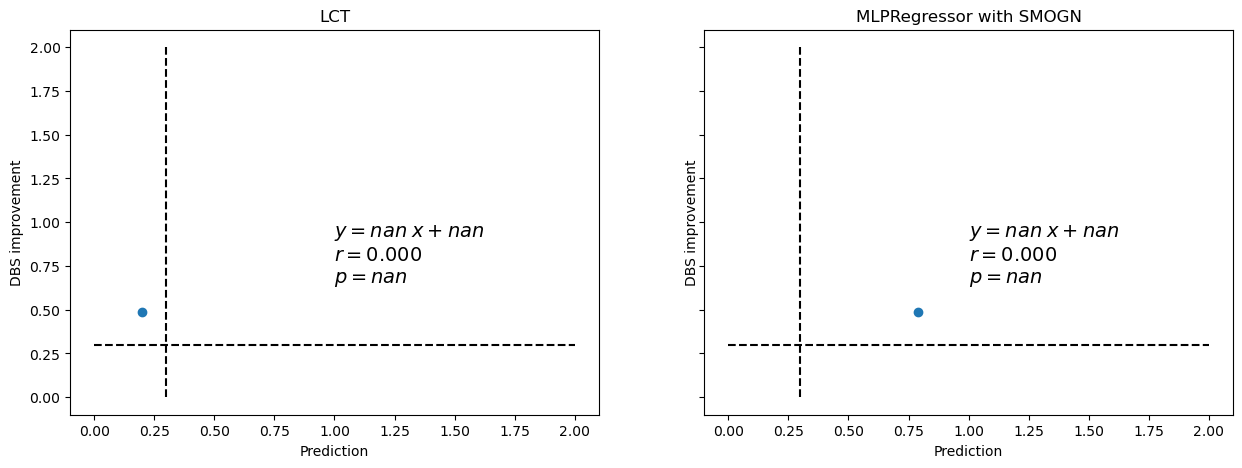

In [ ]:
n = X_test.shape[0]
results = ut_l
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
# Cross validation results
[fig,ax] = plt.subplots(1,2,sharex=True, sharey=True)
lr_prepost = linregress(pre_imp[test_index],y_test)
ax[0].scatter(pre_imp[test_index],y_test)
ax[0].plot(pre_imp[test_index],pre_imp[test_index]*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
# ax[0].set_ylim([0, 1])
# ax[0].set_xlim([0, 1])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.5, 0.5, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')

lr_pred_qr = linregress(np.asarray(ut_l).ravel(),y_test)
ax[1].scatter(np.asarray(ut_l).ravel(),y_test)
ax[1].plot(np.asarray(ut_l).ravel(),np.asarray(ut_l).ravel()*lr_pred_qr.slope+lr_pred_qr.intercept,'-r')
ax[1].set_title('MLPRegressor with SMOGN')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_qr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qr.rvalue:0.3f}$\n$p = {lr_pred_qr.pvalue:0.10f}$"
ax[1].text(0.5, 0.5, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')

plt.style.use('default')
plt.show

In [ ]:
# n = X0_t.shape[0]
# def loop(j):
#         # Reload training data
#         X_in = X_all_c[:n,:,:]
#         per_change_in = per_change[:n]
#         pre_updrs_off_in = pre_updrs_off[:n]
#         # Delete test case
#         X_in = np.delete(X_in,j,axis=0)
#         pre_updrs_off_in = np.delete(pre_updrs_off[:n],j)
#         per_change_in = np.delete(per_change[:n],j)
#         # Concatenate pre-updrs, scale, and reshape
#         X_in_t,scaler = util.make_feature_matrix(X_in,pre_updrs_off_in)
#         reg_l = ElasticNetCV().fit(X_in_t,per_change_in)
#         # Predict
#         X_test = util.scale_feature_matrix(np.expand_dims(X_all_c[j,:,:],axis=0),pre_updrs_off[j],scaler)
#         ut_l = reg_l.predict(X_test.reshape(1, -1))
#         # ut = reg.predict(X_test.reshape(1, -1))
#         print('Predicted improvement of ',ut_l, 'with true improvement', per_change[j])
#         #print('SMOGN predicted improvement of ',ut, 'with true improvement', per_change[j])
#         return ut_l
# pool = Pool(os.cpu_count())
# packet = [*zip(np.arange(n))]
# results = pool.map(loop,np.arange(n))

In [ ]:
# np.save('X_test_in_2.npy',X_test_in)
# np.save('X_train_aug_2.npy',X_train_aug)
# np.save('y_train_aug_2.npy',y_train_aug)